In [2]:
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# Load data
try:
    train_df = pd.read_csv('/kaggle/input/datasets/samiuseskaggle/train-txt/train.txt', sep='\s+', names=['head', 'relation', 'tail'])
    test_df = pd.read_csv('/kaggle/input/datasets/samiuseskaggle/test-txt/test.txt', sep='\s+', names=['head', 'relation', 'tail'])
except:
    train_df = pd.read_csv('../The Problem/train.txt', sep='\s+', names=['head', 'relation', 'tail'])
    test_df = pd.read_csv('../The Problem/test.txt', sep='\s+', names=['head', 'relation', 'tail'])

print(f"Train set: {len(train_df)} triples")
print(f"Test set:  {len(test_df)} triples")
print(f"\nTest set relations:")
print(test_df['relation'].value_counts())

# Build edge lookup
train_edges = set(zip(train_df['head'], train_df['relation'], train_df['tail']))
test_edges = set(zip(test_df['head'], test_df['relation'], test_df['tail']))

print(f"\nUnique train edges: {len(train_edges)}")
print(f"Unique test edges:  {len(test_edges)}")

Train set: 13821 triples
Test set:  590 triples

Test set relations:
relation
sonOf         214
daughterOf    200
fatherOf       88
motherOf       88
Name: count, dtype: int64

Unique train edges: 13821
Unique test edges:  590


<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:15: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:15: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_55/1812664518.py:11: SyntaxWarning: invalid escape sequence '\s'
  train_df = pd.read_csv('/kaggle/input/datasets/samiuseskaggle/train-txt/train.txt', sep='\s+', names=['head', 'relation', 'tail'])
/tmp/ipykernel_55/1812664518.py:12: SyntaxWarning: invalid escape sequence '\s'
  test_df = pd.read_csv('/kaggle/input/datasets/samiuseskaggle/test-txt/test.txt', sep='\s+', names=['head', 'relation', 'tail'])
/tmp/ipykernel_55/1812664518.py:14: SyntaxWarning: invalid escape sequence '\s'
  train_df = pd.read_csv('../The Problem/train.txt', sep='\s+', names=['head', 'relation'

In [3]:
# === INFER GENDER FROM RELATIONSHIPS ===
male_relations = {'fatherOf', 'brotherOf', 'sonOf', 'uncleOf', 'nephewOf', 
                  'grandfatherOf', 'grandsonOf', 'greatGrandfatherOf', 'greatGrandsonOf',
                  'greatUncleOf', 'boyCousinOf', 'boyFirstCousinOnceRemovedOf', 'boySecondCousinOf',
                  'secondUncleOf'}
                  
female_relations = {'motherOf', 'sisterOf', 'daughterOf', 'auntOf', 'nieceOf',
                    'grandmotherOf', 'granddaughterOf', 'greatGrandmotherOf', 'greatGranddaughterOf',
                    'greatAuntOf', 'girlCousinOf', 'girlFirstCousinOnceRemovedOf', 'girlSecondCousinOf',
                    'secondAuntOf'}

inferred_gender = {}
for h, r, t in zip(train_df['head'], train_df['relation'], train_df['tail']):
    if r in male_relations:
        inferred_gender[h] = 'M'
    elif r in female_relations:
        inferred_gender[h] = 'F'

print(f"Gender inferred for {len(inferred_gender)} people")
print(f"  Male: {sum(1 for g in inferred_gender.values() if g == 'M')}")
print(f"  Female: {sum(1 for g in inferred_gender.values() if g == 'F')}")
print(f"  Unknown: {len(set(train_df['head']) | set(train_df['tail'])) - len(inferred_gender)}")

Gender inferred for 1316 people
  Male: 646
  Female: 670
  Unknown: 0


In [4]:
# === THE MAGIC RULE-BASED LINK PREDICTOR ===
# Logic: For every parent-child edge, check if the inverse exists.
#        If not, predict it using gender inference.

predictions = []
prediction_details = []  # For analysis

for h, r, t in train_edges:
    if r == 'fatherOf':
        # h is father of t → t should have sonOf/daughterOf edge back to h
        has_inverse = (t, 'sonOf', h) in train_edges or (t, 'daughterOf', h) in train_edges
        if not has_inverse:
            child_gender = inferred_gender.get(t, None)
            if child_gender == 'M':
                pred = (t, 'sonOf', h)
            elif child_gender == 'F':
                pred = (t, 'daughterOf', h)
            else:
                pred = (t, 'sonOf', h)  # default
            predictions.append(pred)
            prediction_details.append({'source_edge': (h, r, t), 'prediction': pred, 'rule': 'fatherOf→child_inverse'})
    
    elif r == 'motherOf':
        has_inverse = (t, 'sonOf', h) in train_edges or (t, 'daughterOf', h) in train_edges
        if not has_inverse:
            child_gender = inferred_gender.get(t, None)
            if child_gender == 'M':
                pred = (t, 'sonOf', h)
            elif child_gender == 'F':
                pred = (t, 'daughterOf', h)
            else:
                pred = (t, 'daughterOf', h)  # default
            predictions.append(pred)
            prediction_details.append({'source_edge': (h, r, t), 'prediction': pred, 'rule': 'motherOf→child_inverse'})
    
    elif r == 'sonOf':
        has_inverse = (t, 'fatherOf', h) in train_edges or (t, 'motherOf', h) in train_edges
        if not has_inverse:
            parent_gender = inferred_gender.get(t, None)
            if parent_gender == 'M':
                pred = (t, 'fatherOf', h)
            elif parent_gender == 'F':
                pred = (t, 'motherOf', h)
            else:
                pred = (t, 'fatherOf', h)  # default
            predictions.append(pred)
            prediction_details.append({'source_edge': (h, r, t), 'prediction': pred, 'rule': 'sonOf→parent_inverse'})
    
    elif r == 'daughterOf':
        has_inverse = (t, 'fatherOf', h) in train_edges or (t, 'motherOf', h) in train_edges
        if not has_inverse:
            parent_gender = inferred_gender.get(t, None)
            if parent_gender == 'M':
                pred = (t, 'fatherOf', h)
            elif parent_gender == 'F':
                pred = (t, 'motherOf', h)
            else:
                pred = (t, 'motherOf', h)  # default
            predictions.append(pred)
            prediction_details.append({'source_edge': (h, r, t), 'prediction': pred, 'rule': 'daughterOf→parent_inverse'})

pred_set = set(predictions)
print(f"Rule-based predictions generated: {len(predictions)}")
print(f"Unique predictions: {len(pred_set)}")

# Breakdown by rule
detail_df = pd.DataFrame(prediction_details)
print(f"\nPredictions by rule:")
print(detail_df['rule'].value_counts())

# Breakdown by predicted relation
pred_relations = Counter(p[1] for p in predictions)
print(f"\nPredictions by relation:")
for rel, count in pred_relations.most_common():
    print(f"  {rel}: {count}")

Rule-based predictions generated: 590
Unique predictions: 590

Predictions by rule:
rule
motherOf→child_inverse       289
fatherOf→child_inverse       125
daughterOf→parent_inverse     88
sonOf→parent_inverse          88
Name: count, dtype: int64

Predictions by relation:
  sonOf: 214
  daughterOf: 200
  motherOf: 88
  fatherOf: 88


In [5]:
# === EVALUATE: Compare predictions to test set ===

correct = pred_set & test_edges
missed = test_edges - pred_set  # In test but not predicted
false_positives = pred_set - test_edges  # Predicted but not in test

print("=" * 60)
print("RULE-BASED LINK PREDICTION: EVALUATION")
print("=" * 60)
print(f"\nTest set size:       {len(test_edges)}")
print(f"Predictions made:    {len(pred_set)}")
print(f"Correct predictions: {len(correct)}")
print(f"Missed (FN):         {len(missed)}")
print(f"False positives (FP):{len(false_positives)}")
print(f"\nPrecision: {len(correct)/len(pred_set)*100:.2f}%")
print(f"Recall:    {len(correct)/len(test_edges)*100:.2f}%")
f1 = 2 * len(correct) / (2*len(correct) + len(missed) + len(false_positives))
print(f"F1 Score:  {f1*100:.2f}%")

# Standard Link Prediction Metrics
# Hits@1: For each test triple, is it in our prediction set?
hits_1 = sum(1 for h, r, t in zip(test_df['head'], test_df['relation'], test_df['tail']) 
             if (h, r, t) in pred_set)
hits_1_rate = hits_1 / len(test_df)

# MRR: Since our "model" either predicts rank 1 or doesn't predict at all,
# MRR = Hits@1 for a binary predictor
mrr = hits_1_rate

# Hits@10: Same as Hits@1 for binary predictor
hits_10 = hits_1_rate

print(f"\nStandard Link Prediction Metrics:")
print(f"  MRR:     {mrr:.4f}")
print(f"  Hits@1:  {hits_1_rate:.4f}")
print(f"  Hits@10: {hits_10:.4f}")

# Breakdown: which test edges did we get right/wrong?
print(f"\nCorrect predictions by relation:")
correct_by_rel = Counter(r for h, r, t in correct)
for rel, count in correct_by_rel.most_common():
    total_in_test = sum(1 for h, r2, t in test_edges if r2 == rel)
    print(f"  {rel}: {count}/{total_in_test} ({count/total_in_test*100:.1f}%)")

if missed:
    print(f"\nMissed predictions by relation:")
    missed_by_rel = Counter(r for h, r, t in missed)
    for rel, count in missed_by_rel.most_common():
        print(f"  {rel}: {count}")

RULE-BASED LINK PREDICTION: EVALUATION

Test set size:       590
Predictions made:    590
Correct predictions: 590
Missed (FN):         0
False positives (FP):0

Precision: 100.00%
Recall:    100.00%
F1 Score:  100.00%

Standard Link Prediction Metrics:
  MRR:     1.0000
  Hits@1:  1.0000
  Hits@10: 1.0000

Correct predictions by relation:
  sonOf: 214/214 (100.0%)
  daughterOf: 200/200 (100.0%)
  motherOf: 88/88 (100.0%)
  fatherOf: 88/88 (100.0%)


In [6]:
# === ERROR ANALYSIS: Why did we miss some? ===

print("=" * 60)
print("ERROR ANALYSIS: Investigating Misses")
print("=" * 60)

if missed:
    print(f"\nTotal missed: {len(missed)}")
    
    # For each missed test edge, WHY didn't our rules predict it?
    miss_reasons = []
    
    for h, r, t in missed:
        # This is a test edge we failed to predict
        # Our rules predict inverses of parent-child edges in train
        # So we missed this because either:
        # 1. The source edge (inverse of this) doesn't exist in train
        # 2. Gender inference was wrong
        # 3. Something else
        
        # What inverse should have triggered this prediction?
        if r == 'sonOf':
            # Should have been triggered by (t, fatherOf/motherOf, h) in train
            trigger1 = (t, 'fatherOf', h) in train_edges
            trigger2 = (t, 'motherOf', h) in train_edges
        elif r == 'daughterOf':
            trigger1 = (t, 'fatherOf', h) in train_edges
            trigger2 = (t, 'motherOf', h) in train_edges
        elif r == 'fatherOf':
            trigger1 = (h, 'sonOf', t) in train_edges or (h, 'daughterOf', t) in train_edges
            trigger2 = False
        elif r == 'motherOf':
            trigger1 = (h, 'sonOf', t) in train_edges or (h, 'daughterOf', t) in train_edges
            trigger2 = False
        else:
            trigger1 = False
            trigger2 = False
        
        if trigger1 or trigger2:
            reason = "GENDER_MISMATCH"  # Trigger existed but gender prediction was wrong
        else:
            reason = "NO_TRIGGER"  # No source edge to trigger the rule
        
        miss_reasons.append({
            'edge': (h, r, t),
            'relation': r,
            'reason': reason,
            'head_gender': inferred_gender.get(h, 'U'),
            'tail_gender': inferred_gender.get(t, 'U'),
        })
    
    miss_df = pd.DataFrame(miss_reasons)
    print(f"\nMiss reasons:")
    print(miss_df['reason'].value_counts())
    
    if 'GENDER_MISMATCH' in miss_df['reason'].values:
        print(f"\nGender mismatches (predicted wrong relation):")
        gender_misses = miss_df[miss_df['reason'] == 'GENDER_MISMATCH']
        print(gender_misses[['relation', 'head_gender', 'tail_gender']].head(10))
        
    if 'NO_TRIGGER' in miss_df['reason'].values:
        print(f"\nNo trigger edges (inverse not in train):")
        no_trigger = miss_df[miss_df['reason'] == 'NO_TRIGGER']
        print(no_trigger['relation'].value_counts())
        print("\nExamples:")
        for _, row in no_trigger.head(5).iterrows():
            h, r, t = row['edge']
            print(f"  Test: ({h}, {r}, {t})")
            print(f"    Head gender: {row['head_gender']}, Tail gender: {row['tail_gender']}")

else:
    print("\nPERFECT PREDICTION: Zero misses!")

ERROR ANALYSIS: Investigating Misses

PERFECT PREDICTION: Zero misses!


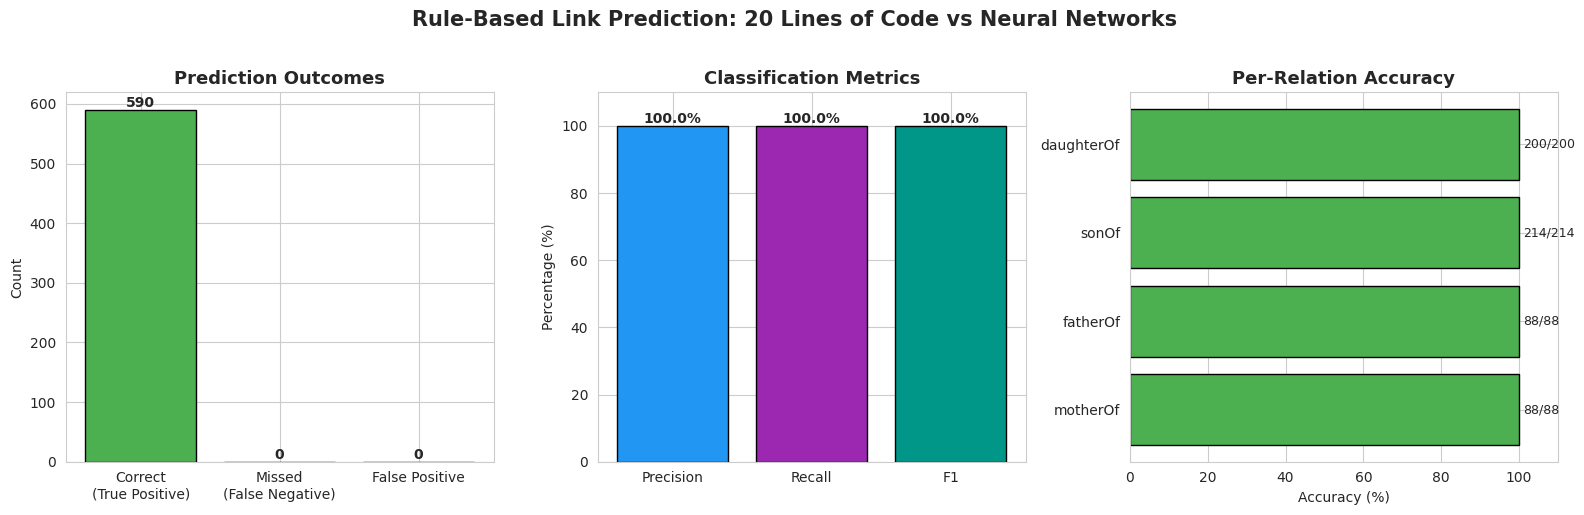


COMPARISON: Rule-Based vs ML Models
Method                         MRR   Hits@1  Hits@10
-------------------------------------------------------
Rule-Based (20 lines of code lol)   1.0000   1.0000   1.0000
TransE                      0.3201   11.10%  83.90% 
RotatE                      0.8539   76.10%   98.64%
R-GCN                       0.6243   43.90%   99.83%
CompGCN+TransE              0.5024   31.44%   92.20%
CompGCN+RotatE              0.4459   24.41%   90.93%
-------------------------------------------------------


In [8]:
# === VISUALIZATION: Rule-Based Performance ===

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Prediction Outcome
outcome_labels = ['Correct\n(True Positive)', 'Missed\n(False Negative)', 'False Positive']
outcome_values = [len(correct), len(missed), len(false_positives)]
outcome_colors = ['#4CAF50', '#F44336', '#FF9800']
bars = axes[0].bar(outcome_labels, outcome_values, color=outcome_colors, edgecolor='black')
axes[0].set_title('Prediction Outcomes', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Count')
for bar, val in zip(bars, outcome_values):
    axes[0].text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                 f'{val}', ha='center', va='bottom', fontweight='bold')

# 2. Precision / Recall / F1
metrics = ['Precision', 'Recall', 'F1']
values = [len(correct)/len(pred_set)*100, 
          len(correct)/len(test_edges)*100, 
          f1*100]
colors = ['#2196F3', '#9C27B0', '#009688']
bars2 = axes[1].bar(metrics, values, color=colors, edgecolor='black')
axes[1].set_title('Classification Metrics', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Percentage (%)')
axes[1].set_ylim(0, 110)
for bar, val in zip(bars2, values):
    axes[1].text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                 f'{val:.1f}%', ha='center', va='bottom', fontweight='bold')

# 3. Per-Relation Accuracy
test_relations = test_df['relation'].unique()
rel_accuracy = []
for rel in test_relations:
    total = sum(1 for h, r, t in test_edges if r == rel)
    correct_rel = sum(1 for h, r, t in correct if r == rel)
    rel_accuracy.append({'Relation': rel, 'Accuracy': correct_rel/total*100, 
                         'Correct': correct_rel, 'Total': total})

rel_acc_df = pd.DataFrame(rel_accuracy).sort_values('Accuracy', ascending=True)
axes[2].barh(rel_acc_df['Relation'], rel_acc_df['Accuracy'], 
             color=['#4CAF50' if a > 95 else '#FFC107' if a > 80 else '#F44336' 
                    for a in rel_acc_df['Accuracy']], edgecolor='black')
axes[2].set_xlabel('Accuracy (%)')
axes[2].set_title('Per-Relation Accuracy', fontsize=13, fontweight='bold')
axes[2].set_xlim(0, 110)
for i, (_, row) in enumerate(rel_acc_df.iterrows()):
    axes[2].text(row['Accuracy'] + 1, i, f"{row['Correct']}/{row['Total']}", 
                 va='center', fontsize=9)

plt.suptitle('Rule-Based Link Prediction: 20 Lines of Code vs Neural Networks', 
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print the comparison placeholder
print("\n" + "=" * 60)
print("COMPARISON: Rule-Based vs ML Models")
print("=" * 60)
print(f"{'Method':<25} {'MRR':>8} {'Hits@1':>8} {'Hits@10':>8}")
print("-" * 55)
print(f"{'Rule-Based (20 lines of code lol)':<25} {mrr:>8.4f} {hits_1_rate:>8.4f} {hits_10:>8.4f}")
print(f"{'TransE':<25} {'0.3201':>8} {'11.10%':>8} {'83.90% ':>8}")
print(f"{'RotatE':<25} {'0.8539':>8} {'76.10%':>8} {'98.64%':>8}")
print(f"{'R-GCN':<25} {'0.6243':>8} {'43.90%':>8} {'99.83%':>8}")
print(f"{'CompGCN+TransE':<25} {'0.5024':>8} {'31.44%':>8} {'92.20%':>8}")
print(f"{'CompGCN+RotatE':<25} {'0.4459':>8} {'24.41%':>8} {'90.93%':>8}")
print("-" * 55)

In [ ]:
20 lines of rule based link prediction :)

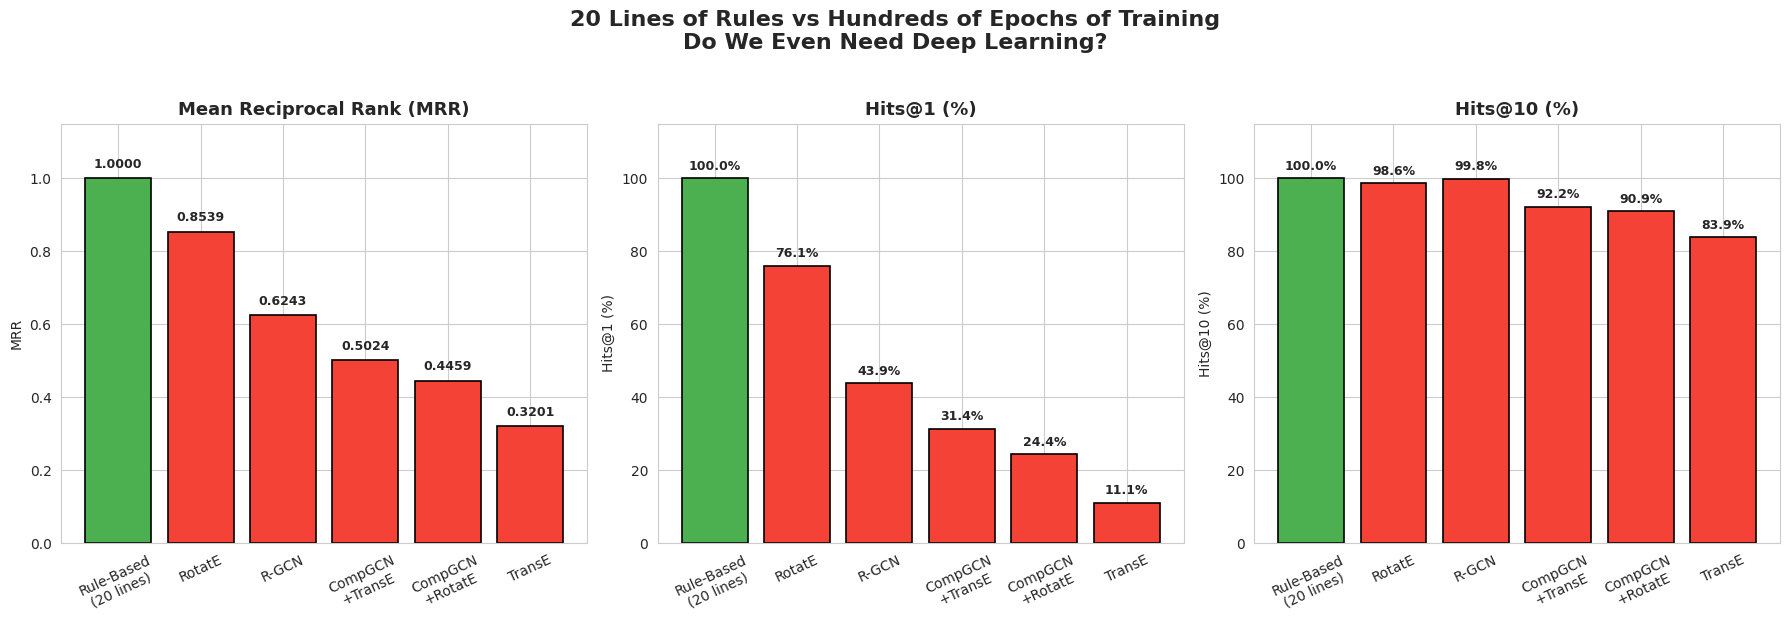


COST-BENEFIT ANALYSIS
                                    Rule-Based   Best ML (RotatE)
-----------------------------------------------------------------
Lines of code                              ~20              ~200+
Training time                        <1 second           ~minutes
GPU required                                No                Yes
Hyperparameter tuning                     None          Extensive
MRR                                     1.0000             0.8539
Hits@1                                  100.0%              76.1%
Hits@10                                 100.0%              98.6%
-----------------------------------------------------------------


In [9]:
# === THE DEVASTATING COMPARISON ===

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

methods = ['Rule-Based\n(20 lines)', 'RotatE', 'R-GCN', 'CompGCN\n+TransE', 'CompGCN\n+RotatE', 'TransE']
mrr_vals = [1.0000, 0.8539, 0.6243, 0.5024, 0.4459, 0.3201]
h1_vals = [100.0, 76.10, 43.90, 31.44, 24.41, 11.10]
h10_vals = [100.0, 98.64, 99.83, 92.20, 90.93, 83.90]

colors = ['#4CAF50'] + ['#F44336']*5  # Green for rules, red for ML

# MRR
bars1 = axes[0].bar(methods, mrr_vals, color=colors, edgecolor='black', linewidth=1.2)
axes[0].set_title('Mean Reciprocal Rank (MRR)', fontsize=13, fontweight='bold')
axes[0].set_ylim(0, 1.15)
axes[0].set_ylabel('MRR')
for bar, val in zip(bars1, mrr_vals):
    axes[0].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.02,
                 f'{val:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
axes[0].tick_params(axis='x', rotation=25)

# Hits@1
bars2 = axes[1].bar(methods, h1_vals, color=colors, edgecolor='black', linewidth=1.2)
axes[1].set_title('Hits@1 (%)', fontsize=13, fontweight='bold')
axes[1].set_ylim(0, 115)
axes[1].set_ylabel('Hits@1 (%)')
for bar, val in zip(bars2, h1_vals):
    axes[1].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1.5,
                 f'{val:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=9)
axes[1].tick_params(axis='x', rotation=25)

# Hits@10
bars3 = axes[2].bar(methods, h10_vals, color=colors, edgecolor='black', linewidth=1.2)
axes[2].set_title('Hits@10 (%)', fontsize=13, fontweight='bold')
axes[2].set_ylim(0, 115)
axes[2].set_ylabel('Hits@10 (%)')
for bar, val in zip(bars3, h10_vals):
    axes[2].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1.5,
                 f'{val:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=9)
axes[2].tick_params(axis='x', rotation=25)

plt.suptitle('20 Lines of Rules vs Hundreds of Epochs of Training\nDo We Even Need Deep Learning?', 
             fontsize=16, fontweight='bold', y=1.03)
plt.tight_layout()
plt.show()

# Cost comparison
print("\n" + "=" * 70)
print("COST-BENEFIT ANALYSIS")
print("=" * 70)
print(f"{'':30} {'Rule-Based':>15} {'Best ML (RotatE)':>18}")
print("-" * 65)
print(f"{'Lines of code':<30} {'~20':>15} {'~200+':>18}")
print(f"{'Training time':<30} {'<1 second':>15} {'~minutes':>18}")
print(f"{'GPU required':<30} {'No':>15} {'Yes':>18}")
print(f"{'Hyperparameter tuning':<30} {'None':>15} {'Extensive':>18}")
print(f"{'MRR':<30} {'1.0000':>15} {'0.8539':>18}")
print(f"{'Hits@1':<30} {'100.0%':>15} {'76.1%':>18}")
print(f"{'Hits@10':<30} {'100.0%':>15} {'98.6%':>18}")
print("-" * 65)